# Sim Results: Log Loss and ECE vs Context Length

This notebook loads simulated ICL prediction pickles and plots log loss and ECE across context length (number of ICL examples).

In [1]:
from pathlib import Path
import pickle
import re
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.pipeline import make_pipeline

sns.set(style="whitegrid")

In [2]:
config_path = Path("/home/yk3043@mc.cumc.columbia.edu/EHR-missingness/configs/sim.yaml")
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

predictions_dir = Path(config["predictions_dir"])
experiment_task = config["downstream_task"]

eps = 1e-12
n_bins = 5

In [3]:
from src.data.data_utils import generate_sepsis_cohort

sim_samples = int(config.get("sim_samples", config.get("max_samples", 1000)))
data_seed = int(config.get("split_seed", 0))
train_frac = float(config.get("train_frac", 0.5))

np.random.seed(data_seed)
sim_df = generate_sepsis_cohort(n=sim_samples).copy()
sim_df["subject_id"] = list(range(sim_samples))

rng = np.random.default_rng(data_seed)
subject_ids = sim_df["subject_id"].to_numpy()
rng.shuffle(subject_ids)
split_idx = int(round(train_frac * len(subject_ids)))
train_ids = set(subject_ids[:split_idx])
sim_df["split"] = ["train" if sid in train_ids else "eval" for sid in sim_df["subject_id"]]

features = ["WBC", "MAP", "Lactate", "PCT"]

train_df = sim_df[sim_df["split"] == "train"].copy()
eval_df = sim_df[sim_df["split"] == "eval"].copy()

X_train = train_df[features]
y_train = train_df["boolean_value"].astype(int)

X_eval = eval_df[features]
y_eval = eval_df["boolean_value"].astype(int)

# Logistic regression without missingness indicators
pipe_no_ind = make_pipeline(
    SimpleImputer(strategy="mean"),
    LogisticRegression(max_iter=1000),
)
pipe_no_ind.fit(X_train, y_train)
probs_no_ind_eval = pipe_no_ind.predict_proba(X_eval)[:, 1]
probs_no_ind_eval = np.clip(probs_no_ind_eval, eps, 1 - eps)
ll_no_ind = log_loss(y_eval, probs_no_ind_eval)

# Logistic regression with missingness indicators
pipe_with_ind = make_pipeline(
    SimpleImputer(strategy="mean", add_indicator=True),
    LogisticRegression(max_iter=1000),
)
pipe_with_ind.fit(X_train, y_train)
probs_with_ind_eval = pipe_with_ind.predict_proba(X_eval)[:, 1]
probs_with_ind_eval = np.clip(probs_with_ind_eval, eps, 1 - eps)
ll_with_ind = log_loss(y_eval, probs_with_ind_eval)

y_prevalence_overall = sim_df["boolean_value"].astype(int).mean()
y_prevalence_train = y_train.mean()
y_prevalence_eval = y_eval.mean()

pd.DataFrame(
    {
        "model": ["logreg_no_indicators", "logreg_with_indicators"],
        "log_loss": [ll_no_ind, ll_with_ind],
        "n_train": [len(y_train), len(y_train)],
        "y_prevalence_overall": [y_prevalence_overall, y_prevalence_overall],
        "y_prevalence_train": [y_prevalence_train, y_prevalence_train],
        "y_prevalence_eval": [y_prevalence_eval, y_prevalence_eval],
    }
)

,model,log_loss,n_train,y_prevalence_overall,y_prevalence_train,y_prevalence_eval
0,logreg_no_indicators,0.462834,500,0.523,0.506,0.54
1,logreg_with_indicators,0.379373,500,0.523,0.506,0.54


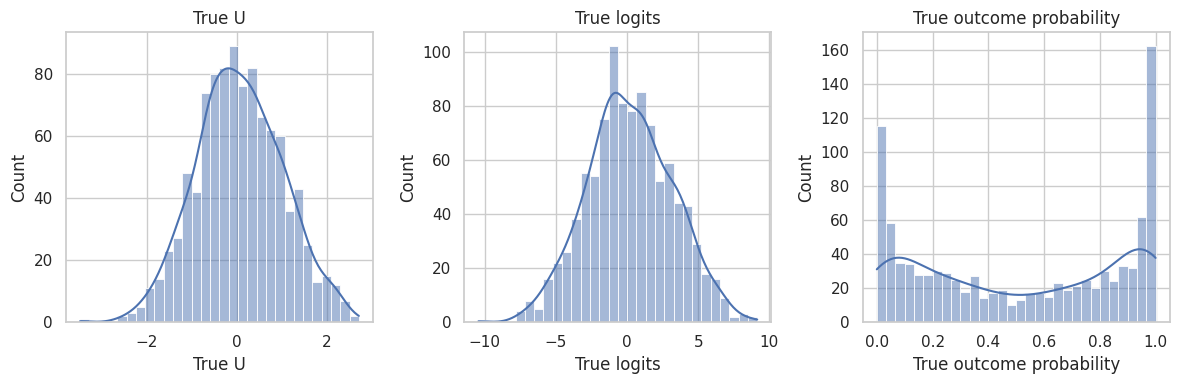

In [4]:
# Distribution of true U and true outcome probability in the simulated dataframe

true_probs = 1 / (1 + np.exp(-sim_df["True_logits"]))
true_logits = sim_df["True_logits"]

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)

sns.histplot(sim_df["True_U"], bins=30, kde=True, ax=axes[0])
axes[0].set_title("True U")
axes[0].set_xlabel("True U")
axes[0].set_ylabel("Count")

sns.histplot(true_logits, bins=30, kde=True, ax=axes[1])
axes[1].set_title("True logits")
axes[1].set_xlabel("True logits")
axes[1].set_ylabel("Count")

sns.histplot(true_probs, bins=30, kde=True, ax=axes[2])
axes[2].set_title("True outcome probability")
axes[2].set_xlabel("True outcome probability")
axes[2].set_ylabel("Count")

plt.tight_layout()


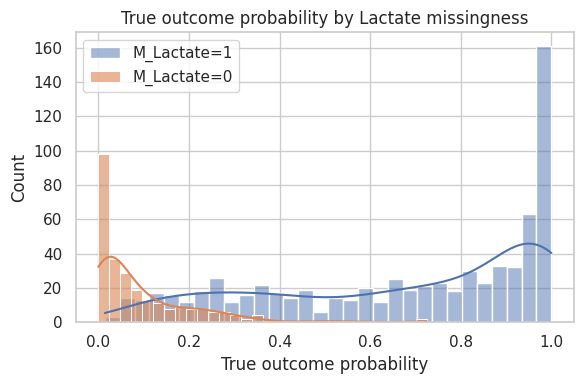

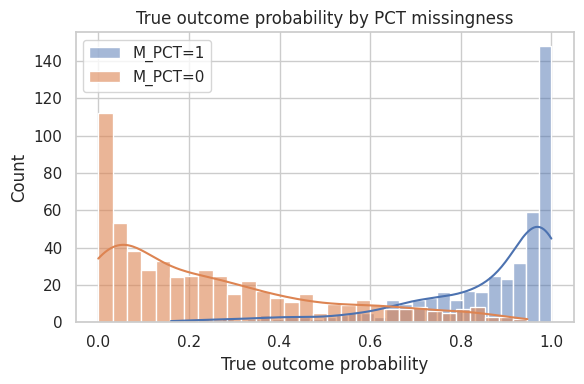

In [5]:
# True outcome probability split by Lactate missingness (M_Lactate)
m_lactate = sim_df["Lactate"].notna()

probs_m = 1 / (1 + np.exp(-sim_df.loc[m_lactate, "True_logits"]))
probs_not_m = 1 / (1 + np.exp(-sim_df.loc[~m_lactate, "True_logits"]))

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.histplot(probs_m, bins=30, kde=True, label="M_Lactate=1", ax=ax, stat="count")
sns.histplot(probs_not_m, bins=30, kde=True, label="M_Lactate=0", ax=ax, stat="count", alpha=0.6)

ax.set_title("True outcome probability by Lactate missingness")
ax.set_xlabel("True outcome probability")
ax.set_ylabel("Count")
ax.legend()

plt.tight_layout()

# True outcome probability split by PCT missingness (M_PCT)
m_pct = sim_df["PCT"].notna()

probs_m_pct = 1 / (1 + np.exp(-sim_df.loc[m_pct, "True_logits"]))
probs_not_m_pct = 1 / (1 + np.exp(-sim_df.loc[~m_pct, "True_logits"]))

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.histplot(probs_m_pct, bins=30, kde=True, label="M_PCT=1", ax=ax, stat="count")
sns.histplot(probs_not_m_pct, bins=30, kde=True, label="M_PCT=0", ax=ax, stat="count", alpha=0.6)

ax.set_title("True outcome probability by PCT missingness")
ax.set_xlabel("True outcome probability")
ax.set_ylabel("Count")
ax.legend()

plt.tight_layout()

In [6]:
# Logistic regression fit on the same context samples as ICL, 
# but evaluate log loss on the 500 test samples (not context/training samples)
# Repeat across multiple seeds for context sample selection and average log loss results

def sample_stratified_ids(subject_dicts_train, num_examples, rng):
    label_map = {0: [], 1: []}
    for subject_id, payload in subject_dicts_train.items():
        label = payload.get("label")
        try:
            label_int = int(label)
        except Exception:
            label_int = 1 if str(label).strip().lower() in ("true", "1", "yes") else 0
        label_map[1 if label_int == 1 else 0].append(subject_id)

    total_ids = label_map[0] + label_map[1]
    if not total_ids:
        return []

    k = min(num_examples, len(total_ids))
    if not label_map[0] or not label_map[1]:
        return rng.sample(total_ids, k)

    prevalence = len(label_map[1]) / len(total_ids)
    k_pos = int(round(k * prevalence))
    k_neg = k - k_pos

    if k >= 2:
        k_pos = max(1, k_pos)
        k_neg = max(1, k - k_pos)
        if k_pos + k_neg != k:
            k_neg = k - k_pos

    k_pos = min(k_pos, len(label_map[1]))
    k_neg = min(k_neg, len(label_map[0]))

    sampled_pos = rng.sample(label_map[1], k_pos)
    sampled_neg = rng.sample(label_map[0], k_neg)
    sampled_ids = sampled_pos + sampled_neg

    if len(sampled_ids) < k:
        remaining = [sid for sid in total_ids if sid not in sampled_ids]
        sampled_ids += rng.sample(remaining, k - len(sampled_ids))

    rng.shuffle(sampled_ids)
    return sampled_ids

results = []

# Prepare test set
eval_df = sim_df[sim_df["split"] == "eval"].copy()
X_eval = eval_df[features]
y_eval = eval_df["boolean_value"].astype(int)

num_seeds = 10  # You can increase for better averaging
seed_values = [data_seed + i for i in range(num_seeds)]  # distinct seeds per run

for selected_icl_num in [20, 50]:
    icl_pool_size = int(config.get("icl_pool_size", selected_icl_num))
    stratified_icl = bool(config.get("icl_stratified", True))

    subject_dicts_train = {
        row.subject_id: {"label": row.boolean_value}
        for row in train_df.itertuples(index=False)
    }

    metrics_runs = []
    metrics_runs_with_ind = []

    for seed in seed_values:
        rng_py = random.Random(seed)
        if stratified_icl:
            context_ids = sample_stratified_ids(subject_dicts_train, icl_pool_size, rng_py)
        else:
            all_train_ids = list(subject_dicts_train.keys())
            k = min(icl_pool_size, len(all_train_ids))
            context_ids = rng_py.sample(all_train_ids, k)

        if selected_icl_num < len(context_ids):
            context_ids = context_ids[:selected_icl_num]

        context_df = train_df[train_df["subject_id"].isin(context_ids)].copy()

        X_context = context_df[features]
        y_context = context_df["boolean_value"].astype(int)

        # Fit on context set, evaluate log loss on test set (eval_df)
        pipe_no_ind_context = make_pipeline(
            SimpleImputer(strategy="mean"),
            LogisticRegression(max_iter=1000),
        )
        pipe_no_ind_context.fit(X_context, y_context)
        probs_no_ind_context = pipe_no_ind_context.predict_proba(X_eval)[:, 1]
        probs_no_ind_context = np.clip(probs_no_ind_context, eps, 1 - eps)
        ll_no_ind_context = log_loss(y_eval, probs_no_ind_context)
        metrics_runs.append(ll_no_ind_context)

        pipe_with_ind_context = make_pipeline(
            SimpleImputer(strategy="mean", add_indicator=True),
            LogisticRegression(max_iter=1000),
        )
        pipe_with_ind_context.fit(X_context, y_context)
        probs_with_ind_context = pipe_with_ind_context.predict_proba(X_eval)[:, 1]
        probs_with_ind_context = np.clip(probs_with_ind_context, eps, 1 - eps)
        ll_with_ind_context = log_loss(y_eval, probs_with_ind_context)
        metrics_runs_with_ind.append(ll_with_ind_context)

    avg_ll_no_ind = np.mean(metrics_runs)
    std_ll_no_ind = np.std(metrics_runs)
    avg_ll_with_ind = np.mean(metrics_runs_with_ind)
    std_ll_with_ind = np.std(metrics_runs_with_ind)

    results.append(
        {
            "model": "logreg_no_indicators_context",
            "log_loss": avg_ll_no_ind,
            "log_loss_std": std_ll_no_ind,
            "n_train": selected_icl_num,
            "icl_num_examples": selected_icl_num,
            "seeds": seed_values,
        }
    )
    results.append(
        {
            "model": "logreg_with_indicators_context",
            "log_loss": avg_ll_with_ind,
            "log_loss_std": std_ll_with_ind,
            "n_train": selected_icl_num,
            "icl_num_examples": selected_icl_num,
            "seeds": seed_values,
        }
    )

pd.DataFrame(results)

,model,log_loss,log_loss_std,n_train,icl_num_examples,seeds
0,logreg_no_indicators_context,0.515668,0.033772,20,20,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
1,logreg_with_indicators_context,0.444983,0.036852,20,20,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
2,logreg_no_indicators_context,0.485817,0.016654,50,50,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
3,logreg_with_indicators_context,0.411976,0.019887,50,50,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"


In [7]:
def compute_ece(labels, preds, n_bins=5, eps=1e-12):
    labels = np.asarray(labels)
    preds = np.asarray(preds)
    preds = np.clip(preds, eps, 1 - eps)

    edges = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    n = len(labels)
    for b in range(n_bins):
        if b < n_bins - 1:
            mask = (preds >= edges[b]) & (preds < edges[b + 1])
        else:
            mask = (preds >= edges[b]) & (preds <= edges[b + 1])
        if not mask.any():
            continue
        conf = preds[mask].mean()
        acc = labels[mask].mean()
        ece += (mask.sum() / n) * abs(acc - conf)
    return ece


def parse_icl_filename(path: Path, task: str):
    name = path.stem
    prefix = f"predictions_{task}_"
    if not name.startswith(prefix):
        return None

    suffix = name[len(prefix):]
    tokens = suffix.split("_")

    # Optional test suffix support: ..._seed1_test5
    test_token = None
    if tokens and tokens[-1].startswith("test"):
        test_token = tokens[-1]
        tokens = tokens[:-1]

    if len(tokens) < 6:
        return None

    seed_token = tokens[-1]
    if not seed_token.startswith("seed"):
        return None

    tokens_no_seed = tokens[:-1]
    if len(tokens_no_seed) < 5:
        return None

    # Supports old and new naming:
    # - iclK for old files
    # - iclK_<sampling> for icl>0 in new files
    # - icl0_baseline for prevalence-adjusted zero-shot files
    if len(tokens_no_seed) >= 6 and not tokens_no_seed[-1].startswith("icl"):
        icl_extra_token = tokens_no_seed[-1].strip().lower()
        icl_token = tokens_no_seed[-2]
        include_cot_token = tokens_no_seed[-3]
        labs_only_token = tokens_no_seed[-4]
        exp_missing_token = tokens_no_seed[-5]
        model = "_".join(tokens_no_seed[:-5])
    else:
        icl_extra_token = None
        icl_token = tokens_no_seed[-1]
        include_cot_token = tokens_no_seed[-2]
        labs_only_token = tokens_no_seed[-3]
        exp_missing_token = tokens_no_seed[-4]
        model = "_".join(tokens_no_seed[:-4])

    if not model:
        return None
    if exp_missing_token not in {"True", "False"}:
        return None
    if labs_only_token not in {"True", "False"}:
        return None
    if include_cot_token not in {"True", "False"}:
        return None
    if not icl_token.startswith("icl"):
        return None

    try:
        icl_num = int(icl_token.replace("icl", ""))
        seed = int(seed_token.replace("seed", ""))
        test_num = int(test_token.replace("test", "")) if test_token else None
    except ValueError:
        return None

    if icl_num == 0:
        if icl_extra_token in {"baseline", "provide_prevalence"}:
            zero_shot_variant = "baseline"
        else:
            zero_shot_variant = "standard"
        icl_sampling_strategy = "none"
    else:
        zero_shot_variant = None
        icl_sampling_strategy = icl_extra_token if icl_extra_token else "random"

    return {
        "task": task,
        "model": model,
        "explicit_missingness": exp_missing_token == "True",
        "labs_only": labs_only_token == "True",
        "include_cot_prompt": include_cot_token == "True",
        "icl_num_examples": icl_num,
        "icl_sampling_strategy": icl_sampling_strategy,
        "zero_shot_variant": zero_shot_variant,
        "seed": seed,
        "test_num_samples": test_num,
    }

In [8]:
records = []
subject_distance_records = []

# Recreate/load the exact same eval set logic as generate_predictions_icl.py
# Priority:
# 1) Load subject_dicts from target_dir (exact file used by inference when present)
# 2) Fallback to deterministic reconstruction using generate_sepsis_cohort + seed split

data_seed_for_gt = int(config.get("data_seed", 0))
split_seed_for_gt = int(config.get("split_seed", data_seed_for_gt))
train_frac_for_gt = float(config.get("train_frac", 0.5))
target_dir_for_gt = Path(config.get("target_dir", "."))

eval_set_cache = {}

def _build_eval_set_and_gt_map(explicit_missingness_flag, labs_only_flag):
    cache_key = (bool(explicit_missingness_flag), bool(labs_only_flag))
    if cache_key in eval_set_cache:
        return eval_set_cache[cache_key]

    # Use the fixed SIM GT dictionary with saved metadata probabilities/logits.
    # This avoids regenerated-probability drift and keeps labels/probs aligned to saved subject_dict.
    subject_dict_path = target_dir_for_gt / (
        f"{experiment_task}_subject_dict_True_True_splitseed-{split_seed_for_gt}.pkl"
    )

    if not subject_dict_path.exists():
        raise FileNotFoundError(
            f"Ground-truth subject_dict not found: {subject_dict_path}. "
            "Generate it first with generate_predictions_icl.py."
        )

    with open(subject_dict_path, "rb") as f:
        data_dicts_gt = pickle.load(f)
    eval_dict_gt = data_dicts_gt.get("eval", data_dicts_gt)

    eval_ids = set(str(subject_id) for subject_id in eval_dict_gt.keys())
    gt_map_local = {}
    for subject_id, payload in eval_dict_gt.items():
        sid = str(subject_id)
        metadata = payload.get("metadata", {}) if isinstance(payload, dict) else {}

        gt_label = payload.get("label") if isinstance(payload, dict) else None
        if gt_label is None:
            continue

        true_logit = metadata.get("True_logits")
        true_prob = metadata.get("true_prob")

        if true_prob is None and true_logit is not None:
            true_logit = float(true_logit)
            true_prob = float(1 / (1 + np.exp(-true_logit)))

        if true_prob is None:
            # Skip if saved GT probability is missing; keeps metrics strictly metadata-backed.
            continue

        gt_map_local[sid] = {
            "boolean_value": int(gt_label),
            "True_logits": float(true_logit) if true_logit is not None else np.nan,
            "true_prob": float(true_prob),
        }

    selected_subject_dict_path = subject_dict_path

    result = {
        "expected_eval_ids": eval_ids,
        "gt_map": gt_map_local,
        "subject_dict_path": str(selected_subject_dict_path),
    }
    eval_set_cache[cache_key] = result
    return result

for path in predictions_dir.glob(f"predictions_{experiment_task}_*_icl*_seed*.pkl"):
    meta = parse_icl_filename(path, experiment_task)
    if meta is None:
        continue

    with open(path, "rb") as f:
        subject_dicts = pickle.load(f)

    eval_info = _build_eval_set_and_gt_map(
        explicit_missingness_flag=meta["explicit_missingness"],
        labs_only_flag=meta["labs_only"],
    )
    expected_eval_ids = eval_info["expected_eval_ids"]
    gt_map = eval_info["gt_map"]

    pred_subject_ids = set(str(subject_id) for subject_id in subject_dicts.keys())
    exact_test_seed_match = pred_subject_ids == expected_eval_ids
    eval_overlap_ratio = (
        len(pred_subject_ids & expected_eval_ids) / len(expected_eval_ids)
        if expected_eval_ids
        else np.nan
    )

    labels_saved = []
    preds_saved = []

    labels_gt = []
    preds_gt = []

    abs_errors = []
    sq_errors = []
    true_probs_run = []
    true_logits_run = []
    label_match_count = 0
    label_match_total = 0

    for subject_id, sd in subject_dicts.items():
        subject_id_str = str(subject_id)
        pred = sd.get("prediction")
        label = sd.get("label")

        if pred is None:
            continue
        pred_float = float(pred)
        if not (0.0 <= pred_float <= 1.0):
            continue

        if label is not None:
            labels_saved.append(int(label))
            preds_saved.append(pred_float)

        gt_entry = gt_map.get(subject_id_str)
        if gt_entry is None:
            continue

        gt_label = int(gt_entry["boolean_value"])
        true_logit = float(gt_entry["True_logits"])
        true_prob = float(gt_entry["true_prob"])

        labels_gt.append(gt_label)
        preds_gt.append(pred_float)

        if label is not None:
            label_match_total += 1
            if int(label) == gt_label:
                label_match_count += 1

        err = pred_float - true_prob
        abs_errors.append(abs(err))
        sq_errors.append(err * err)
        true_probs_run.append(true_prob)
        true_logits_run.append(true_logit)

        subject_distance_records.append(
            {
                **meta,
                "subject_id": subject_id_str,
                "prediction": pred_float,
                "label": int(label) if label is not None else np.nan,
                "gt_label": gt_label,
                "true_logit": true_logit,
                "true_prob": true_prob,
                "abs_error_true_prob": abs(err),
                "sq_error_true_prob": err * err,
                "path": str(path),
                "exact_test_seed_match": exact_test_seed_match,
            }
        )

    if not preds_gt:
        continue

    preds_gt = np.clip(np.array(preds_gt), eps, 1 - eps)
    ll_gt = log_loss(labels_gt, preds_gt)
    ece_gt = compute_ece(labels_gt, preds_gt, n_bins=n_bins, eps=eps)

    # Keep saved-label metrics for diagnostics only
    if preds_saved:
        preds_saved = np.clip(np.array(preds_saved), eps, 1 - eps)
        ll_saved = log_loss(labels_saved, preds_saved)
        ece_saved = compute_ece(labels_saved, preds_saved, n_bins=n_bins, eps=eps)
    else:
        ll_saved = np.nan
        ece_saved = np.nan

    try:
        from sklearn.metrics import roc_auc_score
        auroc_gt = roc_auc_score(labels_gt, preds_gt) if len(set(labels_gt)) > 1 else np.nan
    except Exception:
        auroc_gt = np.nan

    mae_true_prob = float(np.mean(abs_errors)) if abs_errors else np.nan
    rmse_true_prob = float(np.sqrt(np.mean(sq_errors))) if sq_errors else np.nan

    record = {
        **meta,
        "n": len(preds_gt),
        "n_with_true_prob": len(abs_errors),
        # Primary metrics: aligned by subject_id against gt labels
        "log_loss": ll_gt,
        "ece": ece_gt,
        "auroc": auroc_gt,
        # Diagnostics: metrics using labels embedded in prediction files
        "log_loss_saved_label": ll_saved,
        "ece_saved_label": ece_saved,
        "n_saved_label": len(preds_saved) if isinstance(preds_saved, np.ndarray) else len(preds_saved),
        "n_gt_label": len(preds_gt),
        "mae_true_prob": mae_true_prob,
        "rmse_true_prob": rmse_true_prob,
        "mean_true_prob": float(np.mean(true_probs_run)) if true_probs_run else np.nan,
        "mean_true_logit": float(np.mean(true_logits_run)) if true_logits_run else np.nan,
        "exact_test_seed_match": exact_test_seed_match,
        "eval_overlap_ratio": eval_overlap_ratio,
        "label_match_rate": (
            label_match_count / label_match_total if label_match_total else np.nan
        ),
        "path": str(path),
    }
    records.append(record)

results_df = pd.DataFrame(records)
subject_distance_df = pd.DataFrame(subject_distance_records)

results_df

,task,model,explicit_missingness,labs_only,include_cot_prompt,icl_num_examples,icl_sampling_strategy,zero_shot_variant,seed,test_num_samples,...,n_saved_label,n_gt_label,mae_true_prob,rmse_true_prob,mean_true_prob,mean_true_logit,exact_test_seed_match,eval_overlap_ratio,label_match_rate,path
0,sepsis,Qwen3-4B,True,True,False,20,stratified,None,2,None,...,500,500,0.194497,0.245925,0.521503,0.256397,True,1.0,1.0,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...
1,sepsis,Qwen3-4B,True,True,False,20,stratified,None,3,None,...,500,500,0.207354,0.257123,0.521503,0.256397,True,1.0,1.0,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...
2,sepsis,Qwen3-32B,True,True,False,0,none,standard,1,None,...,500,500,0.329151,0.410095,0.521503,0.256397,True,1.0,1.0,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...
3,sepsis,Qwen3-4B,True,True,True,20,stratified,None,2,None,...,500,500,0.200976,0.256403,0.521503,0.256397,True,1.0,1.0,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...
4,sepsis,Qwen3-4B,True,True,False,20,stratified,None,1,None,...,500,500,0.231387,0.283916,0.521503,0.256397,True,1.0,1.0,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...
5,sepsis,Qwen3-32B,True,True,True,20,stratified,None,2,None,...,500,500,0.190693,0.265801,0.521503,0.256397,True,1.0,1.0,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...
6,sepsis,Qwen3-4B,True,True,False,20,stratified,None,4,None,...,500,500,0.225119,0.265957,0.521503,0.256397,True,1.0,1.0,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...
7,sepsis,Qwen3-4B,True,True,True,20,stratified,None,4,None,...,500,500,0.211133,0.259203,0.521503,0.256397,True,1.0,1.0,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...
8,sepsis,Qwen3-32B,True,True,True,20,stratified,None,1,None,...,500,500,0.208216,0.280804,0.521503,0.256397,True,1.0,1.0,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...
9,sepsis,Qwen3-4B,True,True,True,20,stratified,None,1,None,...,498,498,0.230787,0.285567,0.520154,0.247467,True,1.0,1.0,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...


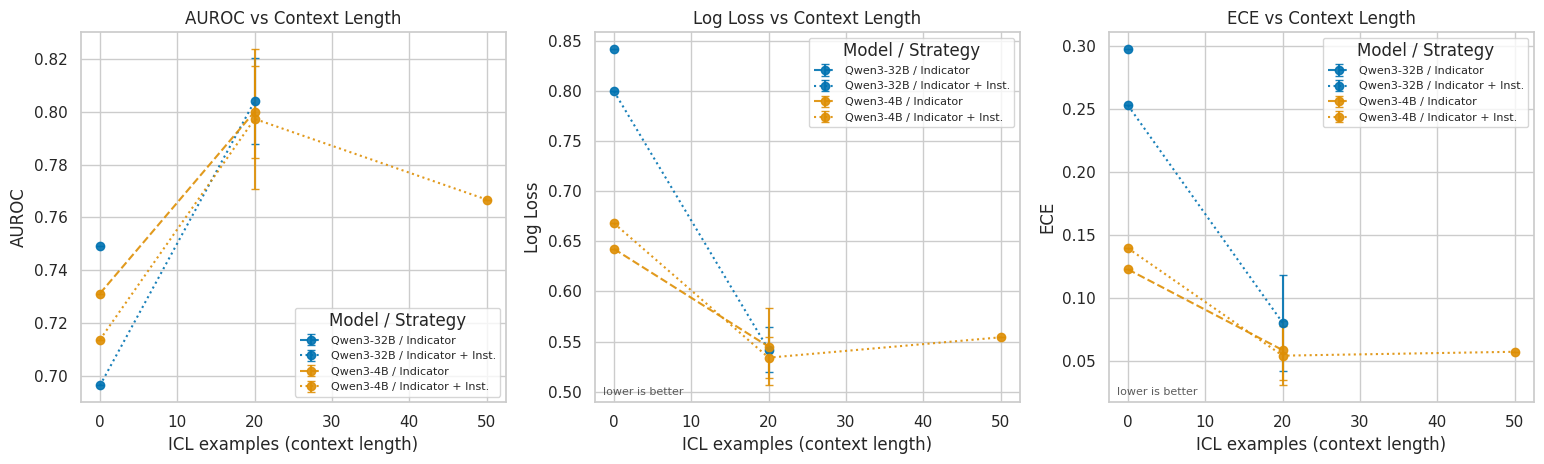

In [9]:
if results_df.empty:
    raise ValueError("No prediction files found. Check predictions_dir and filenames.")

# Color by model, linestyle by strategy (same style as mortality_csv notebook)
strategy_order = ["Dropped", "Indicator", "Indicator + Inst."]
strategy_linestyles = {
    "Dropped": "solid",
    "Indicator": "dashed",
    "Indicator + Inst.": "dotted",
}

plot_df = results_df.copy()
if "serialization_strategy" not in plot_df.columns:
    plot_df["serialization_strategy"] = np.where(
        ~plot_df["explicit_missingness"],
        "Dropped",
        np.where(plot_df["include_cot_prompt"], "Indicator + Inst.", "Indicator"),
    )

# Keep existing exclusion used in this notebook
plot_df = plot_df[plot_df["model"] != "Qwen3-1.7B"].copy()

model_order = sorted(plot_df["model"].unique())
model_palette = sns.color_palette("colorblind", n_colors=len(model_order))
model_color_dict = dict(zip(model_order, model_palette))

plot_df["serialization_strategy"] = pd.Categorical(
    plot_df["serialization_strategy"],
    categories=strategy_order,
    ordered=True,
)
plot_df["model"] = pd.Categorical(
    plot_df["model"],
    categories=model_order,
    ordered=True,
)

candidate_metrics = [
    ("auroc", "AUROC", False),
    ("log_loss", "Log Loss", True),
    ("ece", "ECE", True),
]
metrics = [
    (col, title, lower_is_better)
    for col, title, lower_is_better in candidate_metrics
    if col in plot_df.columns
]

fig, axes = plt.subplots(1, len(metrics), figsize=(5.2 * len(metrics), 4.8), sharex=True)
if len(metrics) == 1:
    axes = [axes]

for ax, (metric_col, title, lower_is_better) in zip(axes, metrics):
    for model in model_order:
        for strategy in strategy_order:
            data = plot_df[
                (plot_df["model"] == model) & (plot_df["serialization_strategy"] == strategy)
            ]
            if data.empty:
                continue

            means = (
                data
                .groupby("icl_num_examples", as_index=False)[metric_col]
                .mean()
            )
            stds = (
                data
                .groupby("icl_num_examples", as_index=False)[metric_col]
                .std()
            )

            x = means["icl_num_examples"]
            y = means[metric_col]
            yerr = stds[metric_col].fillna(0.0)
            if len(x) == 0:
                continue

            ax.errorbar(
                x,
                y,
                yerr=yerr,
                label=f"{model} / {strategy}",
                color=model_color_dict[model],
                linestyle=strategy_linestyles[strategy],
                marker="o",
                capsize=3,
                alpha=0.9,
            )

    ax.set_title(f"{title} vs Context Length")
    ax.set_xlabel("ICL examples (context length)")
    ax.set_ylabel(title)
    ax.legend(fontsize=8, title="Model / Strategy")
    if lower_is_better:
        ax.text(0.02, 0.02, "lower is better", transform=ax.transAxes, fontsize=8, alpha=0.75)

plt.tight_layout()
# save_path = PLOTS_DIR / "sim_context_vs_serialization.pdf"
# plt.savefig(save_path, bbox_inches="tight")
plt.show()
# print("Saved:", save_path)

Ground-truth eval seed check (data_seed=123, train_frac=0.5): 17/17 runs exact-match the eval subject set


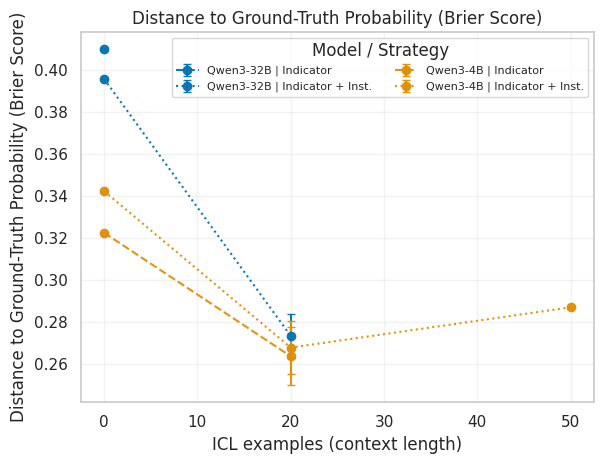

,model,icl_num_examples,seed,subject_id,true_logit,true_prob,label,prediction,abs_error_true_prob
0,Qwen3-4B,20,2,0,-3.627368,0.025898,0,0.25,0.224102
1,Qwen3-4B,20,2,1,-3.219978,0.038421,0,0.35,0.311579
2,Qwen3-4B,20,2,2,1.013402,0.733685,0,0.65,0.083685
3,Qwen3-4B,20,2,3,-0.613708,0.351214,0,0.20,0.151214
4,Qwen3-4B,20,2,8,3.048659,0.954725,1,0.50,0.454725
5,Qwen3-4B,20,2,9,-5.935679,0.002636,0,0.35,0.347364
6,Qwen3-4B,20,2,12,4.727480,0.991229,1,0.95,0.041229
7,Qwen3-4B,20,2,13,-1.250330,0.222643,1,0.30,0.077357
8,Qwen3-4B,20,2,14,-1.500135,0.182405,0,0.25,0.067595
9,Qwen3-4B,20,2,15,2.724588,0.938462,1,0.75,0.188462


In [10]:
# Separate plot: distance to ground-truth probabilities from simulated True_logits

if results_df.empty:
    raise ValueError("No prediction files found. Check predictions_dir and filenames.")

if "mae_true_prob" not in results_df.columns:
    raise ValueError("Distance metric column missing. Re-run the results loading cell above.")

# Subject-level dataframe contains true logits from generate_sepsis_cohort
if subject_distance_df.empty:
    raise ValueError("subject_distance_df is empty. Re-run the results loading cell above.")

print(
    f"Ground-truth eval seed check (data_seed={data_seed_for_gt}, train_frac={train_frac_for_gt}): "
    f"{int(results_df['exact_test_seed_match'].sum())}/{len(results_df)} runs exact-match the eval subject set"
)

mismatch_df = results_df[~results_df["exact_test_seed_match"]][
    ["model", "icl_num_examples", "seed", "eval_overlap_ratio", "path"]
]
if not mismatch_df.empty:
    print("Runs without exact eval-set match (showing up to 10):")
    display(mismatch_df.head(10))

# Run-level plotting setup
strategy_order = ["Dropped", "Indicator", "Indicator + Inst."]
strategy_linestyles = {
    "Dropped": "solid",
    "Indicator": "dashed",
    "Indicator + Inst.": "dotted",
}

distance_plot_df = results_df.copy()
if "serialization_strategy" not in distance_plot_df.columns:
    distance_plot_df["serialization_strategy"] = np.where(
        ~distance_plot_df["explicit_missingness"],
        "Dropped",
        np.where(distance_plot_df["include_cot_prompt"], "Indicator + Inst.", "Indicator"),
    )

# Keep existing exclusion used in this notebook
distance_plot_df = distance_plot_df[distance_plot_df["model"] != "Qwen3-1.7B"].copy()

distance_metric_col = "rmse_true_prob"
distance_metric_title = "Distance to Ground-Truth Probability (Brier Score)"

distance_plot_df = distance_plot_df[np.isfinite(distance_plot_df[distance_metric_col])].copy()
if distance_plot_df.empty:
    raise ValueError("No finite distance metrics available to plot.")

model_order = sorted(distance_plot_df["model"].unique())
model_palette = sns.color_palette("colorblind", n_colors=len(model_order))
model_color_dict = dict(zip(model_order, model_palette))

fig, ax = plt.subplots(figsize=(6.2, 4.8))

for model in model_order:
    for strategy in strategy_order:
        data = distance_plot_df[
            (distance_plot_df["model"] == model)
            & (distance_plot_df["serialization_strategy"] == strategy)
        ]
        if data.empty:
            continue

        means = data.groupby("icl_num_examples", as_index=False)[distance_metric_col].mean()
        stds = data.groupby("icl_num_examples", as_index=False)[distance_metric_col].std().fillna(0.0)

        x = means["icl_num_examples"].to_numpy()
        y = means[distance_metric_col].to_numpy()
        yerr = stds[distance_metric_col].to_numpy()

        ax.errorbar(
            x,
            y,
            yerr=yerr,
            label=f"{model} | {strategy}",
            color=model_color_dict[model],
            linestyle=strategy_linestyles.get(strategy, "solid"),
            marker="o",
            capsize=3,
            alpha=0.95,
        )

ax.set_title(distance_metric_title)
ax.set_xlabel("ICL examples (context length)")
ax.set_ylabel(distance_metric_title)
ax.grid(True, alpha=0.25)
ax.legend(fontsize=8, title="Model / Strategy", ncol=2)

plt.tight_layout()
plt.show()

# Confirm true logits are available at subject level
subject_distance_df[[
    "model", "icl_num_examples", "seed", "subject_id", "true_logit", "true_prob", "label", "prediction", "abs_error_true_prob"
]].head(10)

In [12]:
# Print example reasoning traces for a specific model/ICL length/CoT
selected_model = "Qwen3-32B"  # substring to match in filename model id
selected_icl_num = 50
selected_cot = True
icl_strategy = "stratified"

examples_to_show = 5
max_chars = 10000
shown = 0

pattern = (
    f"predictions_{experiment_task}_*_{selected_cot}_icl{selected_icl_num}_{icl_strategy}_seed*.pkl"
)
example_paths = list(predictions_dir.glob(pattern))

filtered_paths = [p for p in example_paths if selected_model in p.name]

for path in filtered_paths:
    with open(path, "rb") as f:
        subject_dicts = pickle.load(f)

    meta = parse_icl_filename(path, experiment_task)
    if meta is not None:
        eval_info = _build_eval_set_and_gt_map(
            explicit_missingness_flag=meta["explicit_missingness"],
            labs_only_flag=meta["labs_only"],
        )
        gt_map = eval_info["gt_map"]
    else:
        gt_map = {}

    for subject_id, sd in subject_dicts.items():
        response = sd.get("response")
        if not response:
            continue

        subject_id_str = str(subject_id)
        true_label = sd.get("label")
        gt_entry = gt_map.get(subject_id_str)
        gt_prob = gt_entry.get("true_prob") if gt_entry is not None else None

        print(
            f"\n=== {path.name} | subject_id={subject_id} | true_label={true_label} | gt_prob={gt_prob} ==="
        )
        print(response[:max_chars])
        shown += 1
        if shown >= examples_to_show:
            break

    if shown >= examples_to_show:
        break

if shown == 0:
    print("No responses found for the selected filters.")


=== predictions_sepsis_Qwen3-32B_True_True_True_icl50_stratified_seed4.pkl | subject_id=1 | true_label=0 | gt_prob=0.9391715463354707 ===
1. **CLINICAL ASSESSMENT**  
   - **WBC (White Blood Cell Count):** The value is 0.03 (z-score), which is slightly above the mean but not significantly abnormal. This suggests no strong evidence of infection or leukopenia.
   - **MAP (Mean Arterial Pressure):** The value is 2.72 (z-score), which is significantly elevated. High MAP is typically not directly associated with Septic Shock (which is characterized by hypotension), but it may indicate a compensatory response to early systemic stress.
   - **Lactate and PCT:** Both are not measured. Lactate is a strong marker for sepsis severity and acidosis, while PCT is a useful marker for bacterial infection. Their absence limits the ability to detect systemic inflammation or shock.

   Overall, the observed physiology does not strongly indicate Septic Shock, but the missing values reduce diagnostic conf

In [11]:
# # Show cases where predictions are invalid
# # Print example reasoning traces for a specific model/ICL length/CoT
# selected_model = "Qwen3-4B"  # substring to match in filename model id
# selected_icl_num = 50
# selected_cot = False

# max_cases = 10
# max_chars = 5000
# shown = 0

# all_paths = list(predictions_dir.glob(f"predictions_{experiment_task}_*_icl*_seed*.pkl"))

# for path in all_paths:
#     meta = parse_icl_filename(path, experiment_task)
#     if meta is None:
#         continue
#     if selected_model is not None and selected_model not in path.name:
#         continue
#     if selected_icl_num is not None and meta.get("icl_num_examples") != selected_icl_num:
#         continue
#     if selected_cot is not None and meta.get("include_cot_prompt") != selected_cot:
#         continue

#     with open(path, "rb") as f:
#         subject_dicts = pickle.load(f)

#     for subject_id, sd in subject_dicts.items():
#         pred = sd.get("prediction")
#         label = sd.get("label")
#         is_invalid = pred is None
#         if not is_invalid:
#             try:
#                 pred_val = float(pred)
#                 is_invalid = not (0.0 <= pred_val <= 1.0)
#             except Exception:
#                 is_invalid = True

#         if not is_invalid:
#             continue

#         response = sd.get("response", "")
#         print(f"\n=== {path.name} | subject_id={subject_id} ===")
#         print(f"label={label} | prediction={pred}")
#         if response:
#             print(response[:max_chars])
#         else:
#             print("<no response saved>")

#         shown += 1
#         if shown >= max_cases:
#             break

#     if shown >= max_cases:
#         break

# if shown == 0:
#     print("No invalid predictions found for the selected filters.")

In [15]:
# Visualize a sample SIM prompt as constructed in src/inference/generate_predictions_icl.py
from IPython.display import Markdown, display
from pathlib import Path
import random

from src.inference.inference_utils import get_detailed_instruct_sim

# Match filtering style used for sample generations above
selected_model = "Qwen3-14B"   # substring in model id; set None for any
selected_icl_num = 50           # set None for any
selected_cot = True             # True / False / None
selected_seed = None            # set int (e.g., 1) or None

max_chars = 12000               # truncate printed prompt for readability


def _sample_stratified_ids(subject_dicts_train, num_examples, rng):
    label_map = {0: [], 1: []}
    for subject_id, payload in subject_dicts_train.items():
        label = payload.get("label")
        try:
            label_int = int(label)
        except Exception:
            label_int = 1 if str(label).strip().lower() in ("true", "1", "yes") else 0
        label_map[1 if label_int == 1 else 0].append(subject_id)

    total_ids = label_map[0] + label_map[1]
    if not total_ids:
        return []

    k = min(num_examples, len(total_ids))
    if not label_map[0] or not label_map[1]:
        return rng.sample(total_ids, k)

    prevalence = len(label_map[1]) / len(total_ids)
    k_pos = int(round(k * prevalence))
    k_neg = k - k_pos

    if k >= 2:
        k_pos = max(1, k_pos)
        k_neg = max(1, k - k_pos)
        if k_pos + k_neg != k:
            k_neg = k - k_pos

    k_pos = min(k_pos, len(label_map[1]))
    k_neg = min(k_neg, len(label_map[0]))

    sampled_pos = rng.sample(label_map[1], k_pos)
    sampled_neg = rng.sample(label_map[0], k_neg)
    sampled_ids = sampled_pos + sampled_neg

    if len(sampled_ids) < k:
        remaining = [sid for sid in total_ids if sid not in sampled_ids]
        sampled_ids += rng.sample(remaining, k - len(sampled_ids))

    rng.shuffle(sampled_ids)
    return sampled_ids


def _format_icl_examples(subject_dicts_train, num_examples, rng, stratified=True, pool_size=None):
    subject_ids = list(subject_dicts_train.keys())
    if not subject_ids:
        return ""

    if pool_size is None:
        pool_size = num_examples

    if stratified:
        sampled_ids = _sample_stratified_ids(subject_dicts_train, pool_size, rng)
    else:
        k = min(pool_size, len(subject_ids))
        sampled_ids = rng.sample(subject_ids, k)

    if num_examples < len(sampled_ids):
        sampled_ids = sampled_ids[:num_examples]

    example_blocks = []
    for i, subject_id in enumerate(sampled_ids, start=1):
        serialization = subject_dicts_train[subject_id]["serialization"]
        label = subject_dicts_train[subject_id]["label"]
        try:
            label_bool = bool(int(label))
        except Exception:
            label_bool = str(label).strip().lower() in ("true", "1", "yes")

        example_blocks.append(
            "### Example {idx}\n{serialization}\nAnswer: {label}\n".format(
                idx=i,
                serialization=serialization,
                label="True" if label_bool else "False",
            )
        )

    return "\n".join(example_blocks).strip()


def _build_icl_prompt_sim(instruction, examples_block, target_serialization):
    prompt = instruction.strip()
    if examples_block:
        prompt += "\n\nHere are some labeled examples from this hospital:\n"
        prompt += examples_block
        prompt += "\n\nNow output response for the next patient.\n"
    prompt += "\n### Patient\n"
    prompt += target_serialization
    prompt += "\n### Response:\n"
    return prompt


all_paths = sorted(predictions_dir.glob(f"predictions_{experiment_task}_*_icl*_seed*.pkl"))
chosen_path = None
chosen_meta = None

for path in all_paths:
    meta = parse_icl_filename(path, experiment_task)
    if meta is None:
        continue
    if selected_model is not None and selected_model not in meta["model"]:
        continue
    if selected_icl_num is not None and meta["icl_num_examples"] != selected_icl_num:
        continue
    if selected_seed is not None and meta["seed"] != selected_seed:
        continue
    if selected_cot is not None and meta["include_cot_prompt"] != selected_cot:
        continue

    chosen_path = path
    chosen_meta = meta
    break

if chosen_path is None:
    print("No matching prediction run found for the selected filters.")
else:
    pred_subject_dicts = pickle.load(open(chosen_path, "rb"))
    if not isinstance(pred_subject_dicts, dict) or len(pred_subject_dicts) == 0:
        print(f"Could not load predictions from {chosen_path.name}")
    else:
        sample_subject_id = next(iter(pred_subject_dicts.keys()))
        sample_item = pred_subject_dicts[sample_subject_id]
        target_serialization = sample_item.get("serialization", "")

        subject_dict_path = (
            Path(config["target_dir"])
            / f"{experiment_task}_subject_dict_{chosen_meta['explicit_missingness']}_{chosen_meta['labs_only']}.pkl"
        )

        if not subject_dict_path.exists():
            print(f"Training/eval subject_dict not found: {subject_dict_path}")
        else:
            data_dicts = pickle.load(open(subject_dict_path, "rb"))
            if not isinstance(data_dicts, dict) or "train" not in data_dicts:
                print(f"Unexpected subject_dict structure in: {subject_dict_path}")
            else:
                cfg = {
                    "task_query": config.get("task_query", "Predict probability of septic shock within 24h."),
                    "include_cot_prompt": bool(chosen_meta["include_cot_prompt"]),
                    "icl_num_examples": int(chosen_meta["icl_num_examples"]),
                }

                rng = random.Random(chosen_meta["seed"])
                icl_num_examples = int(chosen_meta["icl_num_examples"])
                icl_pool_size = int(config.get("icl_pool_size", icl_num_examples))
                stratified_icl = bool(config.get("icl_stratified", True))

                examples_block = _format_icl_examples(
                    data_dicts["train"],
                    num_examples=icl_num_examples,
                    rng=rng,
                    stratified=stratified_icl,
                    pool_size=icl_pool_size,
                )

                instruction = get_detailed_instruct_sim(cfg)
                if icl_num_examples == 0:
                    sample_prompt = instruction + target_serialization
                else:
                    sample_prompt = _build_icl_prompt_sim(instruction, examples_block, target_serialization)

                display(
                    Markdown(
                        f"### Sample reconstructed SIM prompt (`generate_predictions_icl.py`)\n"
                        f"- file: `{chosen_path.name}`  \n"
                        f"- model: `{chosen_meta['model']}` | CoT: `{chosen_meta['include_cot_prompt']}` | "
                        f"icl: `{chosen_meta['icl_num_examples']}` | seed: `{chosen_meta['seed']}`  \n"
                        f"- subject_id: `{sample_subject_id}`"
                    )
                )

                print(sample_prompt[:max_chars])
                if len(sample_prompt) > max_chars:
                    print("\n[Prompt truncated. Increase max_chars to print full prompt.]\n")
                print("\n" + "-" * 100 + "\n")

                if examples_block:
                    display(Markdown("#### ICL examples block used in this prompt"))
                    print(examples_block)
                    print("\n" + "-" * 100 + "\n")

### Sample reconstructed SIM prompt (`generate_predictions_icl.py`)
- file: `predictions_sepsis_Qwen3-14B_True_True_True_icl50_seed1.pkl`  
- model: `Qwen3-14B` | CoT: `True` | icl: `50` | seed: `1`  
- subject_id: `1`

You are an expert Clinical Risk Estimation System analyzing a synthetic patient record. Your goal is to estimate the risk of Septic Shock within 24 hours.

Please provide your analysis step-by-step using the following structure:

1. CLINICAL ASSESSMENT: Analyze the patient's risk based on the observed physiology (WBC, MAP, etc.).
2. MISSINGNESS MECHANISM: Analyze WHY specific features are missing. Consider whether their absence is potentially informative of the outcome.
3. PATTERN RECOGNITION: Look at the few-shot examples provided. Identify any hospital-specific risk patterns and correlations using (a) observed values and (b) whether a feature is measured or not).

After your analysis, you must output the final probability in a strictly valid JSON block at the very end of your response. Use this format:
```json
{
  "prediction_prob": 0.0 to 1.0
}
```

Here are some labeled examples from this hospital:
### Example 1

 # Electronic Health Record
## Measurements
- WBC
  - 0.65 (standardi

#### ICL examples block used in this prompt

### Example 1

 # Electronic Health Record
## Measurements
- WBC
  - 0.65 (standardized; z-score)
- MAP
  - 0.79 (standardized; z-score)
- Lactate
  - -0.51 (standardized; z-score)
- PCT
  - 0.32 (standardized; z-score)

Answer: True

### Example 2

 # Electronic Health Record
## Measurements
- WBC
  - 0.42 (standardized; z-score)
- MAP
  - 0.75 (standardized; z-score)
- Lactate
  - -0.36 (standardized; z-score)
- PCT
  - 0.79 (standardized; z-score)

Answer: True

### Example 3

 # Electronic Health Record
## Measurements
- WBC
  - -0.37 (standardized; z-score)
- MAP
  - -0.05 (standardized; z-score)
- Lactate
  - Not measured
- PCT
  - Not measured

Answer: False

### Example 4

 # Electronic Health Record
## Measurements
- WBC
  - 0.84 (standardized; z-score)
- MAP
  - -1.84 (standardized; z-score)
- Lactate
  - 1.72 (standardized; z-score)
- PCT
  - -0.19 (standardized; z-score)

Answer: True

### Example 5

 # Electronic Health Record
## Measurements
- WBC
  - -0.00 (standardized;